In [ ]:
# create a piecewise linear transform to a quantum register
# |x> where x_i < x < x_{i+1}, x integer
# y_i + (x - x_i)  

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt


from qiskit import execute, Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation
from qiskit.circuit.library import NormalDistribution, LogNormalDistribution, LinearAmplitudeFunction, IntegerComparator, WeightedAdder
from qiskit.visualization import plot_histogram

In [81]:
num_state_qubits = 3

# circuit for norma distribution
sigma = 1
low = -3
high = 3
mu = 0
norm_circ = NormalDistribution(num_state_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

# circuit for conditional multiply by 1, plus 2
weights_mult_by_1 = []
for n in [num_state_qubits, num_state_qubits]:
    for i in range(n):
        weights_mult_by_1 += [2**i * 1]

mult_by_1 = WeightedAdder(num_state_qubits * 2, weights_mult_by_1)
cond_mult_by_1 = mult_by_1.to_gate().control()

# circuit for conditional multiply by 2
weights_mult_by_2 = []
for i in range(num_state_qubits):
    weights_mult_by_2 += [2**i * 2]

mult_by_2 = WeightedAdder(num_state_qubits, weights_mult_by_2)
cond_mult_by_2 = mult_by_2.to_gate().control()

# circuit to add results
weights_add = []
for n in [mult_by_1.num_sum_qubits, mult_by_2.num_sum_qubits]:
    for i in range(n):
        weights_add += [2**i * 1]

add = WeightedAdder(mult_by_1.num_sum_qubits + mult_by_2.num_sum_qubits, weights_add)

#print("Adder needs: {0} qubits".format(weighted_times1.num_qubits))

point = 3
comparator = IntegerComparator(num_state_qubits=num_state_qubits, value=point) # if true if i >= point

qr_state = QuantumRegister(3, 'state')
qr_const = QuantumRegister(3, 'const') # can be classical (with different building blocks!)

state_out = ClassicalRegister(add.num_sum_qubits, 'state_out')
#state_out_2 = ClassicalRegister(weighted_times1.num_sum_qubits, 'state_out_2')
qr_control = QuantumRegister(1, 'control')
qr_control_2 = QuantumRegister(1, 'control_2')
#print("Running total sum: {0} qubits".format(weighted_times2.num_sum_qubits))

qr_sum_1 = QuantumRegister(mult_by_1.num_sum_qubits, 'sum_1') # times 1
qr_sum_2 = QuantumRegister(mult_by_2.num_sum_qubits, 'sum_2') # times 2
qr_sum_3 = QuantumRegister(add.num_sum_qubits, 'sum_3')

print("Final sum: {0} qubits".format(weighted_times1.num_sum_qubits))
#qr_anc_comp = AncillaRegister(comparator.num_ancilla_qubits, 'anc_comp')
#qr_anc = AncillaRegister(weighted_times1.num_ancilla_qubits, 'anc') # max number

qr_anc = AncillaRegister(add.num_ancilla_qubits, 'anc') # add.num_ancilla_qubits # mult_by_2.num_ancilla_qubits
#qr_anc2 = AncillaRegister(weighted_times1.num_ancilla_qubits, 'anc2')

circ = QuantumCircuit(qr_state, qr_const, qr_control, qr_control_2, state_out, qr_sum_1, qr_sum_2, qr_sum_3, qr_anc) #, qr_anc2) 

circ.append(norm_circ, qr_state)
circ.append(comparator, qr_state[:] + qr_control[:] + qr_anc[0:comparator.num_ancilla_qubits])
circ.x(qr_const[1])
circ.x(qr_control_2)
circ.cx(qr_control, qr_control_2)

circ.append(cond_mult_by_2, qr_control_2[:] + qr_state[:] + qr_sum_2[:] + qr_anc[0:mult_by_2.num_ancilla_qubits])
circ.append(cond_mult_by_1, qr_control[:] + qr_state[:] + qr_const[:] + qr_sum_1[:] + qr_anc[0:mult_by_1.num_ancilla_qubits])
circ.append(add, qr_sum_1[:] + qr_sum_2[:] + qr_sum_3[:] + qr_anc[0:add.num_ancilla_qubits])

#circ.reset(qr_sum_temp)

circ.measure(qr_sum_3, state_out)
#circ.measure(qr_sum_temp, state_out)

circ.draw()

Final sum: 4 qubits


┌───────┐┌──────┐     ┌─────────┐┌─────────┐                    »
    state_0: ┤0      ├┤0     ├─────┤0        ├┤0        ├────────────────────»
             │       ││      │     │         ││         │                    »
    state_1: ┤1 P(X) ├┤1     ├─────┤1        ├┤1        ├────────────────────»
             │       ││      │     │         ││         │                    »
    state_2: ┤2      ├┤2     ├─────┤2        ├┤2        ├────────────────────»
             └───────┘│      │     │         ││         │                    »
    const_0: ─────────┤      ├─────┤         ├┤3        ├────────────────────»
               ┌───┐  │      │     │         ││         │                    »
    const_1: ──┤ X ├──┤      ├─────┤         ├┤4        ├────────────────────»
               └───┘  │      │     │         ││         │                    »
    const_2: ─────────┤      ├─────┤         ├┤5        ├────────────────────»
                      │      │     │         ││         │                    »
  control_0: ─────────┤3     ├──■──┤         ├■         ├────────────────────»
               ┌───┐  │      │┌─┴─┐│         ││         │                    »
control_2_0: ──┤ X ├──┤      ├┤ X ├■         ├┤         ├────────────────────»
               └───┘  │      │└───┘│         ││         │┌─────────┐         »
    sum_1_0: ─────────┤      ├─────┤         ├┤6        ├┤0        ├─────────»
                      │      │     │         ││         ││         │         »
    sum_1_1: ─────────┤      ├─────┤         ├┤7        ├┤1        ├─────────»
                      │      │     │         ││         ││         │         »
    sum_1_2: ─────────┤      ├─────┤         ├┤8        ├┤2        ├─────────»
                      │      │     │         ││         ││         │         »
    sum_1_3: ─────────┤  cmp ├─────┤         ├┤9        ├┤3        ├─────────»
                      │      │     │         ││         ││         │         »
    sum_2_0: ─────────┤      ├─────┤3  adder ├┤   adder ├┤4        ├─────────»
                      │      │     │         ││         ││         │         »
    sum_2_1: ─────────┤      ├─────┤4        ├┤         ├┤5        ├─────────»
                      │      │     │         ││         ││         │         »
    sum_2_2: ─────────┤      ├─────┤5        ├┤         ├┤6        ├─────────»
                      │      │     │         ││         ││         │         »
    sum_2_3: ─────────┤      ├─────┤6        ├┤         ├┤7        ├─────────»
                      │      │     │         ││         ││         │┌─┐      »
    sum_3_0: ─────────┤      ├─────┤         ├┤         ├┤8        ├┤M├──────»
                      │      │     │         ││         ││   adder │└╥┘┌─┐   »
    sum_3_1: ─────────┤      ├─────┤         ├┤         ├┤9        ├─╫─┤M├───»
                      │      │     │         ││         ││         │ ║ └╥┘┌─┐»
    sum_3_2: ─────────┤      ├─────┤         ├┤         ├┤10       ├─╫──╫─┤M├»
                      │      │     │         ││         ││         │ ║  ║ └╥┘»
    sum_3_3: ─────────┤      ├─────┤         ├┤         ├┤11       ├─╫──╫──╫─»
                      │      │     │         ││         ││         │ ║  ║  ║ »
    sum_3_4: ─────────┤      ├─────┤         ├┤         ├┤12       ├─╫──╫──╫─»
                      │      │     │         ││         ││         │ ║  ║  ║ »
      anc_0: ─────────┤4     ├─────┤7        ├┤10       ├┤13       ├─╫──╫──╫─»
                      │      │     │         ││         ││         │ ║  ║  ║ »
      anc_1: ─────────┤5     ├─────┤8        ├┤11       ├┤14       ├─╫──╫──╫─»
                      └──────┘     │         ││         ││         │ ║  ║  ║ »
      anc_2: ──────────────────────┤9        ├┤12       ├┤15       ├─╫──╫──╫─»
                                   │         ││         ││         │ ║  ║  ║ »
      anc_3: ──────────────────────┤10       ├┤13       ├┤16       ├─╫──╫──╫─»
                                   └─────────┘└─────────┘│     

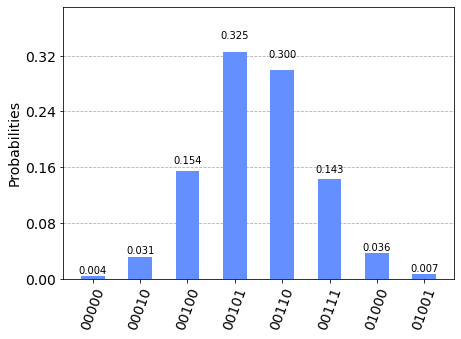

In [82]:
counts = execute(circ, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)

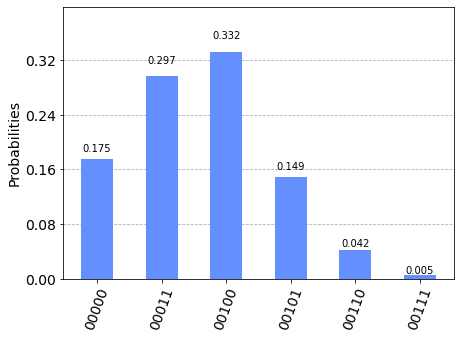

In [9]:
counts = execute(circ, Aer.get_backend('qasm_simulator')).result().get_counts()
plot_histogram(counts)